# Adaptive Filter
This notebooks uses the "padasip" module to create Apadative Filters for time series prediction.

In [1]:
import csv, os

import matplotlib.pyplot as plt
import numpy as np
import padasip as pa
import pandas as pd

Functions for importing stock dividend data

In [2]:
# Split Dataframe into train and test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

def get_stock_data():
    # Collect list of all companies we have data for

    # Get list of file names
    fileList = os.listdir("../data/series/good")

    # Loop through file names and collect ticker symbols
    companyList = []
    for file in fileList:
        companyName = file.split("_")[0]
        if companyName not in [".DS",".ipynb"]:
            companyList.append(companyName)

    # Add to ignore list if no data is available
    # Yahoo Finance will occasionally not through error
    # for some companies during GetMetrics, which end up creating blank
    # csvs that we can simply ignore here
    ignoreList = ["FFMR","FMCB"]
    stockList = list(set(companyList).difference(ignoreList))

    # Load and store data in initial Dataframe
    df_ = {}
    for i in stockList:
        df_[i] = pd.read_csv("../data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])

    # Create new Dataframe that contains data for each company
    # split at specified year
    df_new = {}
    for i in stockList:
        df_new[i] = {}
        df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2006", "0")
    
    return df_new

Overwritting the AdaptiveFilter class to include an optimization function avialable on a different branch of padasip.

In [3]:
class AdaptiveFilter(pa.filters.base_filter.AdaptiveFilter):
    def explore_learning(self, d, x, mu_start=0, mu_end=1., steps=100, ntrain=0.5, epochs=1, criteria="MSE", target_w=False):
        mu_range = np.linspace(mu_start, mu_end, steps)
        errors = np.zeros(len(mu_range))
        for i, mu in enumerate(mu_range):
            # init
            self.init_weights("zeros")
            self.mu = mu
            # run
            y, e, w = self.pretrained_run(d, x, ntrain=ntrain, epochs=epochs)
            if type(target_w) != bool:
                errors[i] = self.get_mean_error(w[-1]-target_w, function=criteria)
            else:
                errors[i] = self.get_mean_error(e, function=criteria)
        return errors, mu_range    
    

    def get_valid_error(self, x1, x2=-1):
        if type(x2) == int and x2 == -1:
            try:    
                e = np.array(x1)
            except:
                raise ValueError('Impossible to convert series to a numpy array')        
        # two series
        else:
            try:
                x1 = np.array(x1)
                x2 = np.array(x2)
            except:
                raise ValueError('Impossible to convert one of series to a numpy array')
            if not len(x1) == len(x2):
                raise ValueError('The length of both series must agree.')
            e = x1 - x2
        return e

    def logSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return 10*np.log10(e**2)


    def MAE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sum(np.abs(e)) / float(len(e))

    def MSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.dot(e, e) / float(len(e))

    def RMSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sqrt(np.dot(e, e) / float(len(e)))

    def get_mean_error(self, x1, x2=-1, function="MSE"):
        if function == "MSE":
            return self.MSE(x1, x2)
        elif function == "MAE":
            return self.MAE(x1, x2)
        elif function == "RMSE":
            return self.RMSE(x1, x2)
        else:
            raise ValueError('The provided error function is not known')

In [4]:
def get_data(ticker):
    filename = f"{DATA_DIR}/{ticker}_dividends_fixed.csv"
    data = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        reader.__next__()
        for row in reader:
            data.append(float(row[1]))
    return np.array(data)

In [86]:
def create_filter(data, n, filter_type='NLMS'):
    if n == 1:
        x = np.reshape(data,(data.shape[0],1))
    else:
        x = np.squeeze(pa.input_from_history(data, n)) # Input matrix
    N = len(x)
    d = np.zeros(N) # Intialize target with empty values
    for i, k in enumerate(range((n-1), N)):
        # Fill target with our desired values
        if n == 1:
            d[i] = data[k]
        else:
            d[i] = data[k+1]
    f = AdaptiveFilter(n=n, mu=0)
    errors_e, mu_range = f.explore_learning(d, x,
                mu_start=0.01,
                mu_end=1.,
                steps=100, ntrain=0.5, epochs=1,
                criteria="MSE")

    best_mu = mu_range[errors_e.argmin()]
    
    # f = pa.filters.AdaptiveFilter(model=filter_type, n=n, mu=0.01, w="random")
    f = pa.filters.AdaptiveFilter(model=filter_type, n=n, mu=best_mu, w="random")
    y, e, w = f.run(d, x)
    return  y, e, w, f

def predict_filter(data, n, plot, f):
    x = np.squeeze(pa.input_from_history(data, n)) # Input matrix
    y = []
    for step in x:
        y.append(f.predict(step))
    
    if n == 1:
        return np.asarray(y).transpose()[0]
    return np.asarray(y)

def fit_filter(data, n, ticker):
    y_train, e_train, w_train, f = create_filter(data[ticker]['Train'].values, n, filter_type='NLMS')
    y_test  = predict_filter(data[ticker]['Test'].values, n, False, f)
    y = np.append(y_train, y_test)
    d = data[ticker]['Train'].append( data[ticker]['Test'])
    train = pd.Series(data=y_train , index=data[ticker]['Train'].index[n-1:])
    test = pd.Series(data=y_test , index=data[ticker]['Test'].index[n-1:])
    plot_filter_result(train, test, d, e_train, n, ticker)
    return y_test

In [87]:
def plot_filter_result(pred_train, pred_test, actual, error, n, tkr):   
    plt.figure(figsize=(12.5, 20))
    plt.subplot(411)
    plt.xlabel('No of iteration [-]')
    a = actual.plot(title=tkr, ylabel='Dividends')
    tr = pred_train.plot()
    ts = pred_test.plot()
    plt.legend(['Actual', 'Train Predictions', 'Test Predictions'], loc='upper left')
    if n > 1:
        _avg_error = round(np.mean(10*np.log10(error[: (len(error) - n)]**2)), 2)
        plt.subplot(412)
        plt.title(f'Filter error (avg: {_avg_error})')
        plt.plot(10*np.log10(error[: (len(error) - n)]**2), 'r', label='Error')
        plt.axhline(y=_avg_error, color='black', lw=1, linestyle='--')
    plt.tight_layout()
    plt.show()


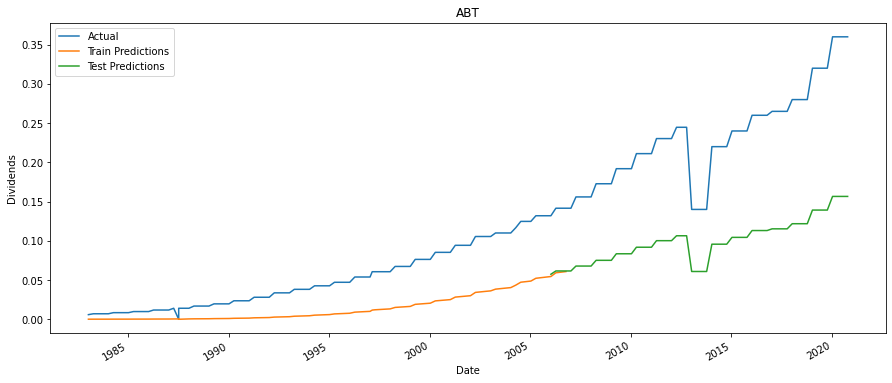

In [89]:
data = get_stock_data()
n = 1
ticker = 'ABT'
preds = fit_filter(data, n, ticker)

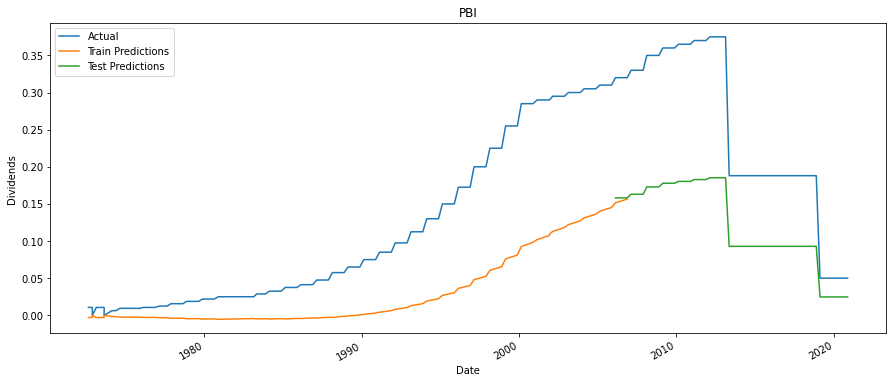

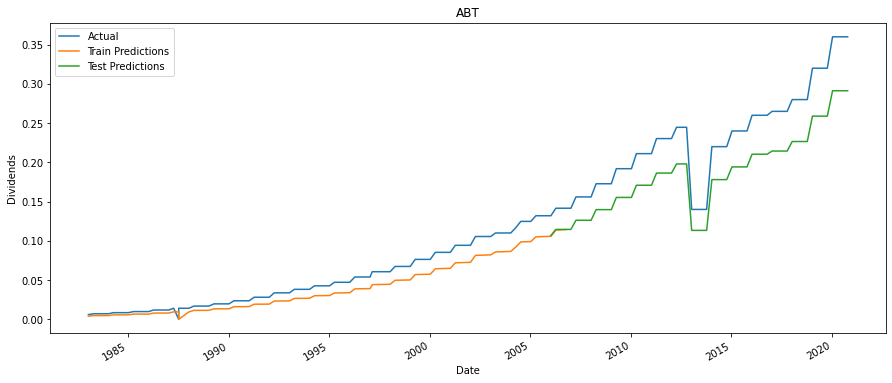

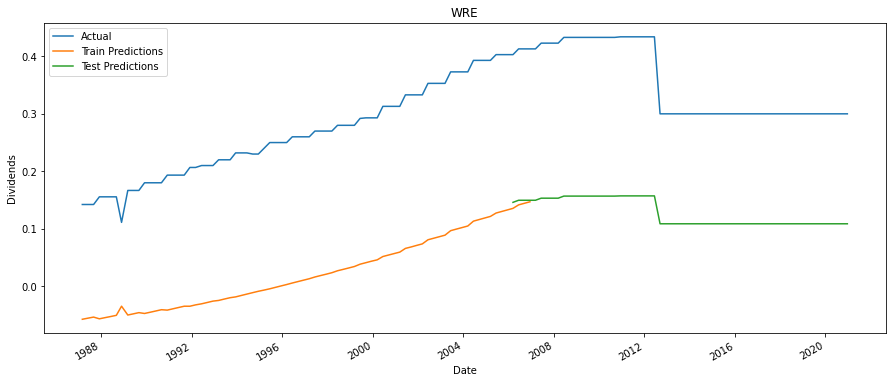

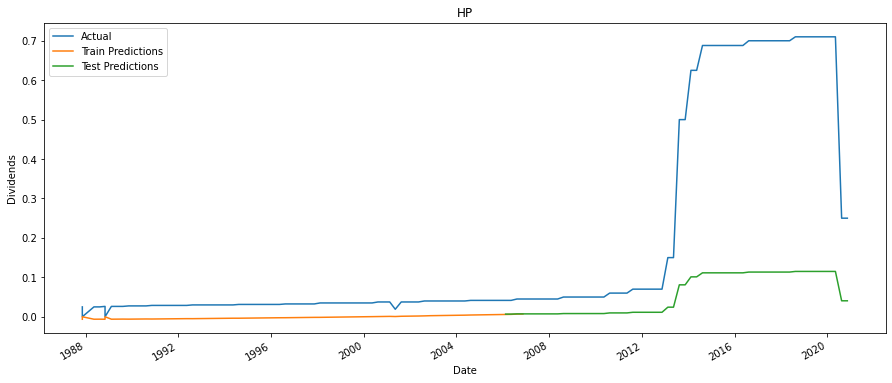

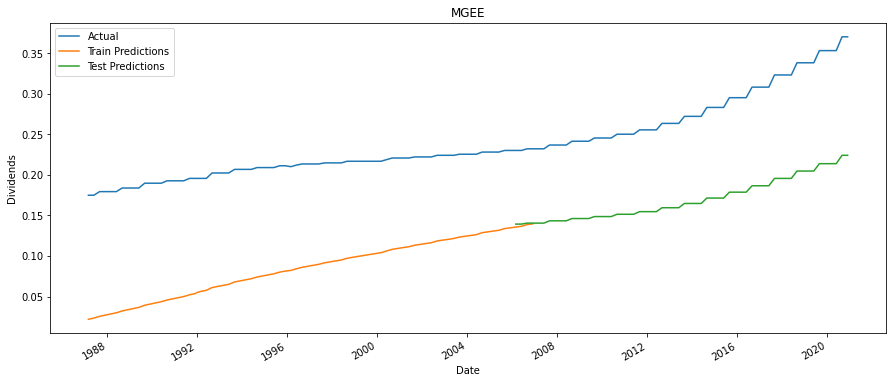

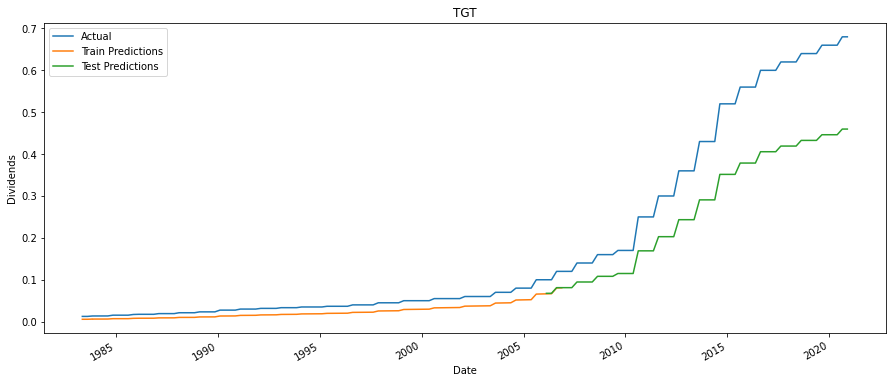

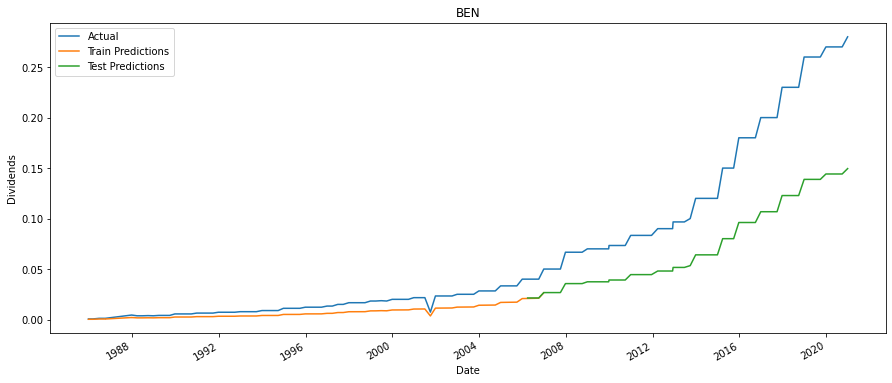

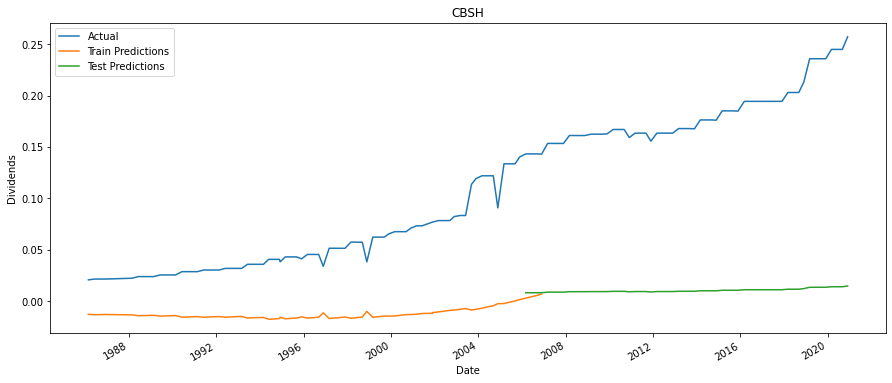

In [90]:
n = 1
lost_figs = ['PBI', 'ABT', 'WRE', 'HP']
kept_figs = ['MGEE', 'TGT', 'BEN', 'CBSH']

for t in lost_figs:
    preds = fit_filter(data, n, t)
    np.save(f"../data/numpy/{t}_pred_af", preds)

for t in kept_figs:
    preds = fit_filter(data, n, t)
    np.save(f"../data/numpy/{t}_pred_af", preds)

In [12]:
x_test = np.squeeze(pa.input_from_history(test, n))
d_test = np.zeros(len(x_test))
N_test = len(x_test)
for i, k in enumerate(range((n-1), N_test)):
    d_test[i] = test[k+1]

actual = np.zeros(N_test)
predict = np.zeros(N_test)

# Simulate real-time prediction and update the filter
for k in range(N_test):
    x_input = x_test[k]
    y = f.predict(x_input)
    d_actual = d_test[k]
    f.adapt(d_actual, x_input)
    actual[k] = d_actual
    predict[k] = y
    
## show results
avg_error = np.round(np.mean(10*np.log10((actual -predict)**2)), 4)
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on test data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
plt.legend()
plt.subplot(212)
plt.title(f'Filter error (avg: {avg_error})')
plt.xlabel("Samples [k]")
plt.plot(((actual[n: (len(actual)-n)] - predict[n: (len(predict)-n)])**2), "r", label="Error")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'test' is not defined

In [ ]:
def predict_future(test, preds, n=5):
    x_future = np.squeeze(pa.input_from_history(test, n))
    N_future = len(x_future) + preds
    d_future = np.zeros(N_future)
    
    for i, k in enumerate(range((n-1), len(x_future))):
        d_future[i] = test[k+1]

    actual = np.zeros(len(x_future))
    predict = np.zeros(N_future)
    
    future = x_future[-1]
    for k in range(N_future):
        if k >= len(x_future):    
            future = np.delete(future, 0)
            future = np.append(future, predict[k-1])
            y = f.predict(future)
            predict[k] = y
        else:
            x_input = x_future[k]
            y = f.predict(x_input)
            predict[k] = y
            d_actual = d_future[k]
            f.adapt(d_actual, x_input)
            actual[k] = d_actual
            predict[k] = y
    return actual, predict

In [ ]:
actual, predict = predict_future(test, 5)

## show results
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on test data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
plt.legend()
plt.show()
print(predict[-5:])

In [ ]:
def MSE(predicted, actual):
    return 1/N * np.sum((actual[n: (len(actual)-n)] - predict[n: (len(predict)-n)])**2)

In [ ]:
MSE(predict, actual)

## Comparison

In [ ]:
n = 5
lost_figs = ['PBI', 'ABT', 'WRE', 'HP']
kept_figs = ['MGEE', 'TGT', 'BEN', 'CBSH']

for t in lost_figs:
    data = get_data(t)
    print(t)
    y, e, w  = create_filter(data, n, True, filter_type='NLMS')

for t in kept_figs:
    data = get_data(t)
    print(t)
    y, e, w  = create_filter(data, n, True, filter_type='NLMS')